In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import cmocean.cm as cmo
from xmitgcm import open_mdsdataset

plt.rcParams['font.size'] = 15

In [2]:
filename_state = 'diag_state'

zMin = -250
zMax = 0
lon = 220.0
latMin = -0.1
latMax = 0.1

data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_withhold/run_iter14/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state]
ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds['XC'] = ds.XC.astype(float)
ds['YC'] = ds.YC.astype(float)
ds['Z'] = ds.Z.astype(float)
ds['XG'] = ds.XG.astype(float)
ds['YG'] = ds.YG.astype(float)
ds['Zl'] = ds.Zl.astype(float)

data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_assim/run_iter22/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state]
ds_vel = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds_vel['XC'] = ds.XC.astype(float)
ds_vel['YC'] = ds.YC.astype(float)
ds_vel['Z'] = ds.Z.astype(float)
ds_vel['XG'] = ds.XG.astype(float)
ds_vel['YG'] = ds.YG.astype(float)
ds_vel['Zl'] = ds.Zl.astype(float)

In [3]:
folder_name = '/home/edavenport/analysis/mitgcm-mombudg/velocity_assim/sep2012_UV_compare/'

In [4]:
uvel = ds.UVEL.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
vvel = ds.VVEL.sel(Z=slice(zMax,zMin),YG=slice(latMin,latMax)).sel(XC=[lon],method='nearest').squeeze().compute() # YG is right on the equator

uvel_vel = ds_vel.UVEL.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
vvel_vel = ds_vel.VVEL.sel(Z=slice(zMax,zMin),YG=slice(latMin,latMax)).sel(XC=[lon],method='nearest').squeeze().compute() # YG is right on the equator

In [5]:
from scipy.signal import detrend
# get Vprime
vvel_detrend = detrend(vvel,axis=0,type='linear') 
vvel_anom = vvel_detrend - np.nanmean(vvel_detrend,axis=0)

# get Uprime 
uvel_detrend = detrend(uvel,axis=0,type='linear') 
uvel_anom = uvel_detrend - np.nanmean(uvel_detrend,axis=0)

# get Vprime
vvel_vel_detrend = detrend(vvel_vel,axis=0,type='linear') 
vvel_vel_anom = vvel_vel_detrend - np.nanmean(vvel_vel_detrend,axis=0)

# get Uprime 
uvel_vel_detrend = detrend(uvel_vel,axis=0,type='linear') 
uvel_vel_anom = uvel_vel_detrend - np.nanmean(uvel_vel_detrend,axis=0)


## Basic FFT -> Power Spectrum

In [6]:
N = len(uvel.time)
window = np.hanning(N)*np.ones([len(uvel.Z),1])

v_window = vvel_anom*window.T
Fsst = np.fft.fft(v_window,axis=0)
amp1 = abs(Fsst[:N//2,:]/N)
amp1[1:,:] = 2*amp1[1:,:]
freq_segments = 1/(np.arange(N//2)/N)

u_window = uvel_anom*window.T
Fsst = np.fft.fft(u_window,axis=0)
amp2 = abs(Fsst[:N//2,:]/N)
amp2[1:,:] = 2*amp2[1:,:]

v_window_vel = vvel_vel_anom*window.T
Fsst = np.fft.fft(v_window_vel,axis=0)
amp1_vel = abs(Fsst[:N//2,:]/N)
amp1_vel[1:,:] = 2*amp1_vel[1:,:]

u_window_vel = uvel_vel_anom*window.T
Fsst = np.fft.fft(u_window_vel,axis=0)
amp2_vel = abs(Fsst[:N//2,:]/N)
amp2_vel[1:,:] = 2*amp2_vel[1:,:]

In [7]:
temp = vvel[:len(freq_segments)].copy(deep=True)
temp.values = amp1
amp1 = temp
amp1['time'] = freq_segments
amp1['long_name'] = 'VVEL Power Spectrum'
amp1 = amp1.isel(time=slice(1,None)) # get rid of the zero frequency

temp = uvel[:len(freq_segments)].copy(deep=True)
temp.values = amp2
amp2 = temp
amp2['time'] = freq_segments
amp2['long_name'] = 'UVEL Power Spectrum'
amp2 = amp2.isel(time=slice(1,None)) # get rid of the zero frequency

temp = vvel_vel[:len(freq_segments)].copy(deep=True)
temp.values = amp1_vel
amp1_vel = temp
amp1_vel['time'] = freq_segments
amp1_vel['long_name'] = 'VVEL Power Spectrum'
amp1_vel = amp1_vel.isel(time=slice(1,None)) # get rid of the zero frequency

temp = uvel_vel[:len(freq_segments)].copy(deep=True)
temp.values = amp2_vel
amp2_vel = temp
amp2_vel['time'] = freq_segments
amp2_vel['long_name'] = 'UVEL Power Spectrum'
amp2_vel = amp2_vel.isel(time=slice(1,None)) # get rid of the zero frequency


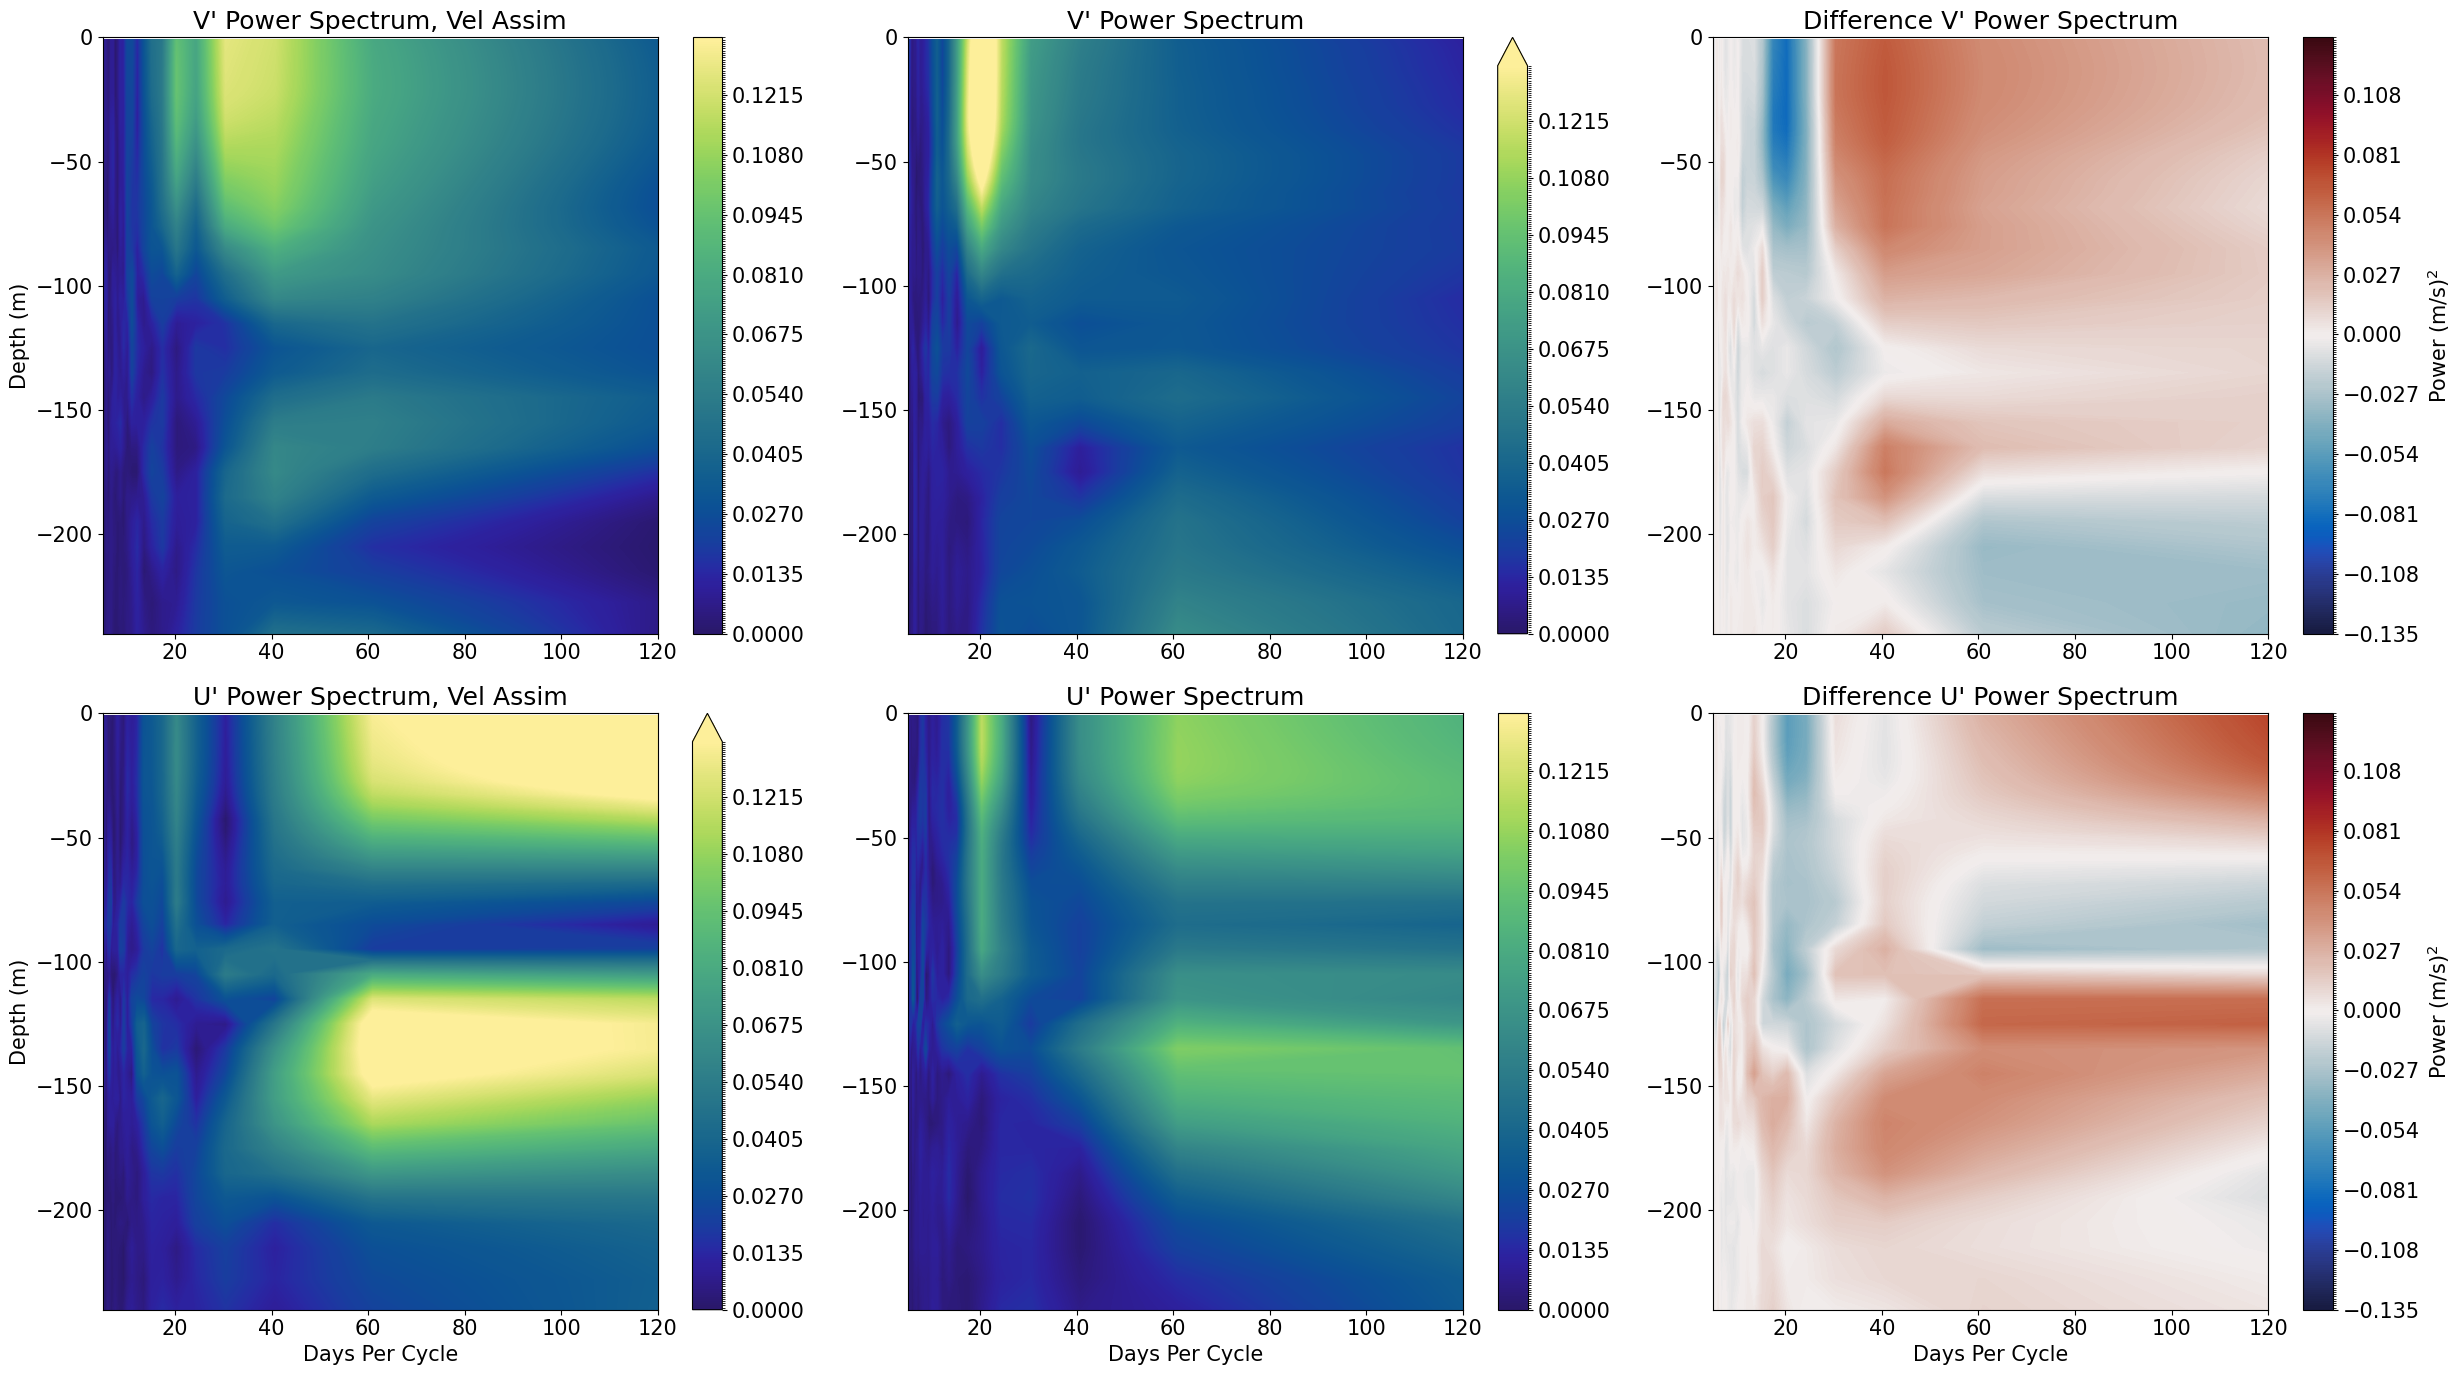

In [13]:
fig, ax = plt.subplots(ncols=3, nrows=2,figsize=(25,14))
levels = np.arange(0,0.135,0.0005)
amp1_vel.plot.contourf(levels=levels,x='time',y='Z',ax=ax[0,0],cmap=cmo.haline,cbar_kwargs={'label': ''})
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Depth (m)')
ax[0,0].set_ylim(-240,0)  
ax[0,0].set_xlim(5,120)
ax[0,0].set_title('V\' Power Spectrum, Vel Assim')

amp2_vel.plot.contourf(levels=levels,x='time',y='Z',ax=ax[1,0],cmap=cmo.haline,cbar_kwargs={'label': ''})
ax[1,0].set_xlabel('Days Per Cycle')
ax[1,0].set_ylabel('Depth (m)')
ax[1,0].set_ylim(-240,0)
ax[1,0].set_xlim(5,120)
ax[1,0].set_title('U\' Power Spectrum, Vel Assim')

amp1.plot.contourf(levels=levels,x='time',y='Z',ax=ax[0,1],cmap=cmo.haline,cbar_kwargs={'label': ''})
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].set_ylim(-240,0)  
ax[0,1].set_xlim(5,120)
ax[0,1].set_title('V\' Power Spectrum')

amp2.plot.contourf(levels=levels,x='time',y='Z',ax=ax[1,1],cmap=cmo.haline,cbar_kwargs={'label': ''})
ax[1,1].set_xlabel('Days Per Cycle')
ax[1,1].set_ylabel('')
ax[1,1].set_ylim(-240,0)
ax[1,1].set_xlim(5,120)
ax[1,1].set_title('U\' Power Spectrum')

levels = np.arange(-0.135,0.135,0.001)
(amp1_vel - amp1).plot.contourf(levels=levels,x='time',y='Z',ax=ax[0,2],cmap=cmo.balance,cbar_kwargs={'label': 'Power (m/s)$^2$'})
ax[0,2].set_xlabel('')
ax[0,2].set_ylabel('')
ax[0,2].set_ylim(-240,0)  
ax[0,2].set_xlim(5,120)
ax[0,2].set_title('Difference V\' Power Spectrum')

(amp2_vel - amp2).plot.contourf(levels=levels,x='time',y='Z',ax=ax[1,2],cmap=cmo.balance,cbar_kwargs={'label': 'Power (m/s)$^2$'})
ax[1,2].set_xlabel('Days Per Cycle')
ax[1,2].set_ylabel('')
ax[1,2].set_ylim(-240,0)
ax[1,2].set_xlim(5,120)
ax[1,2].set_title('Difference U\' Power Spectrum')

plt.tight_layout()
plt.show()

fig.savefig(folder_name+'velocity_spectrum.png')

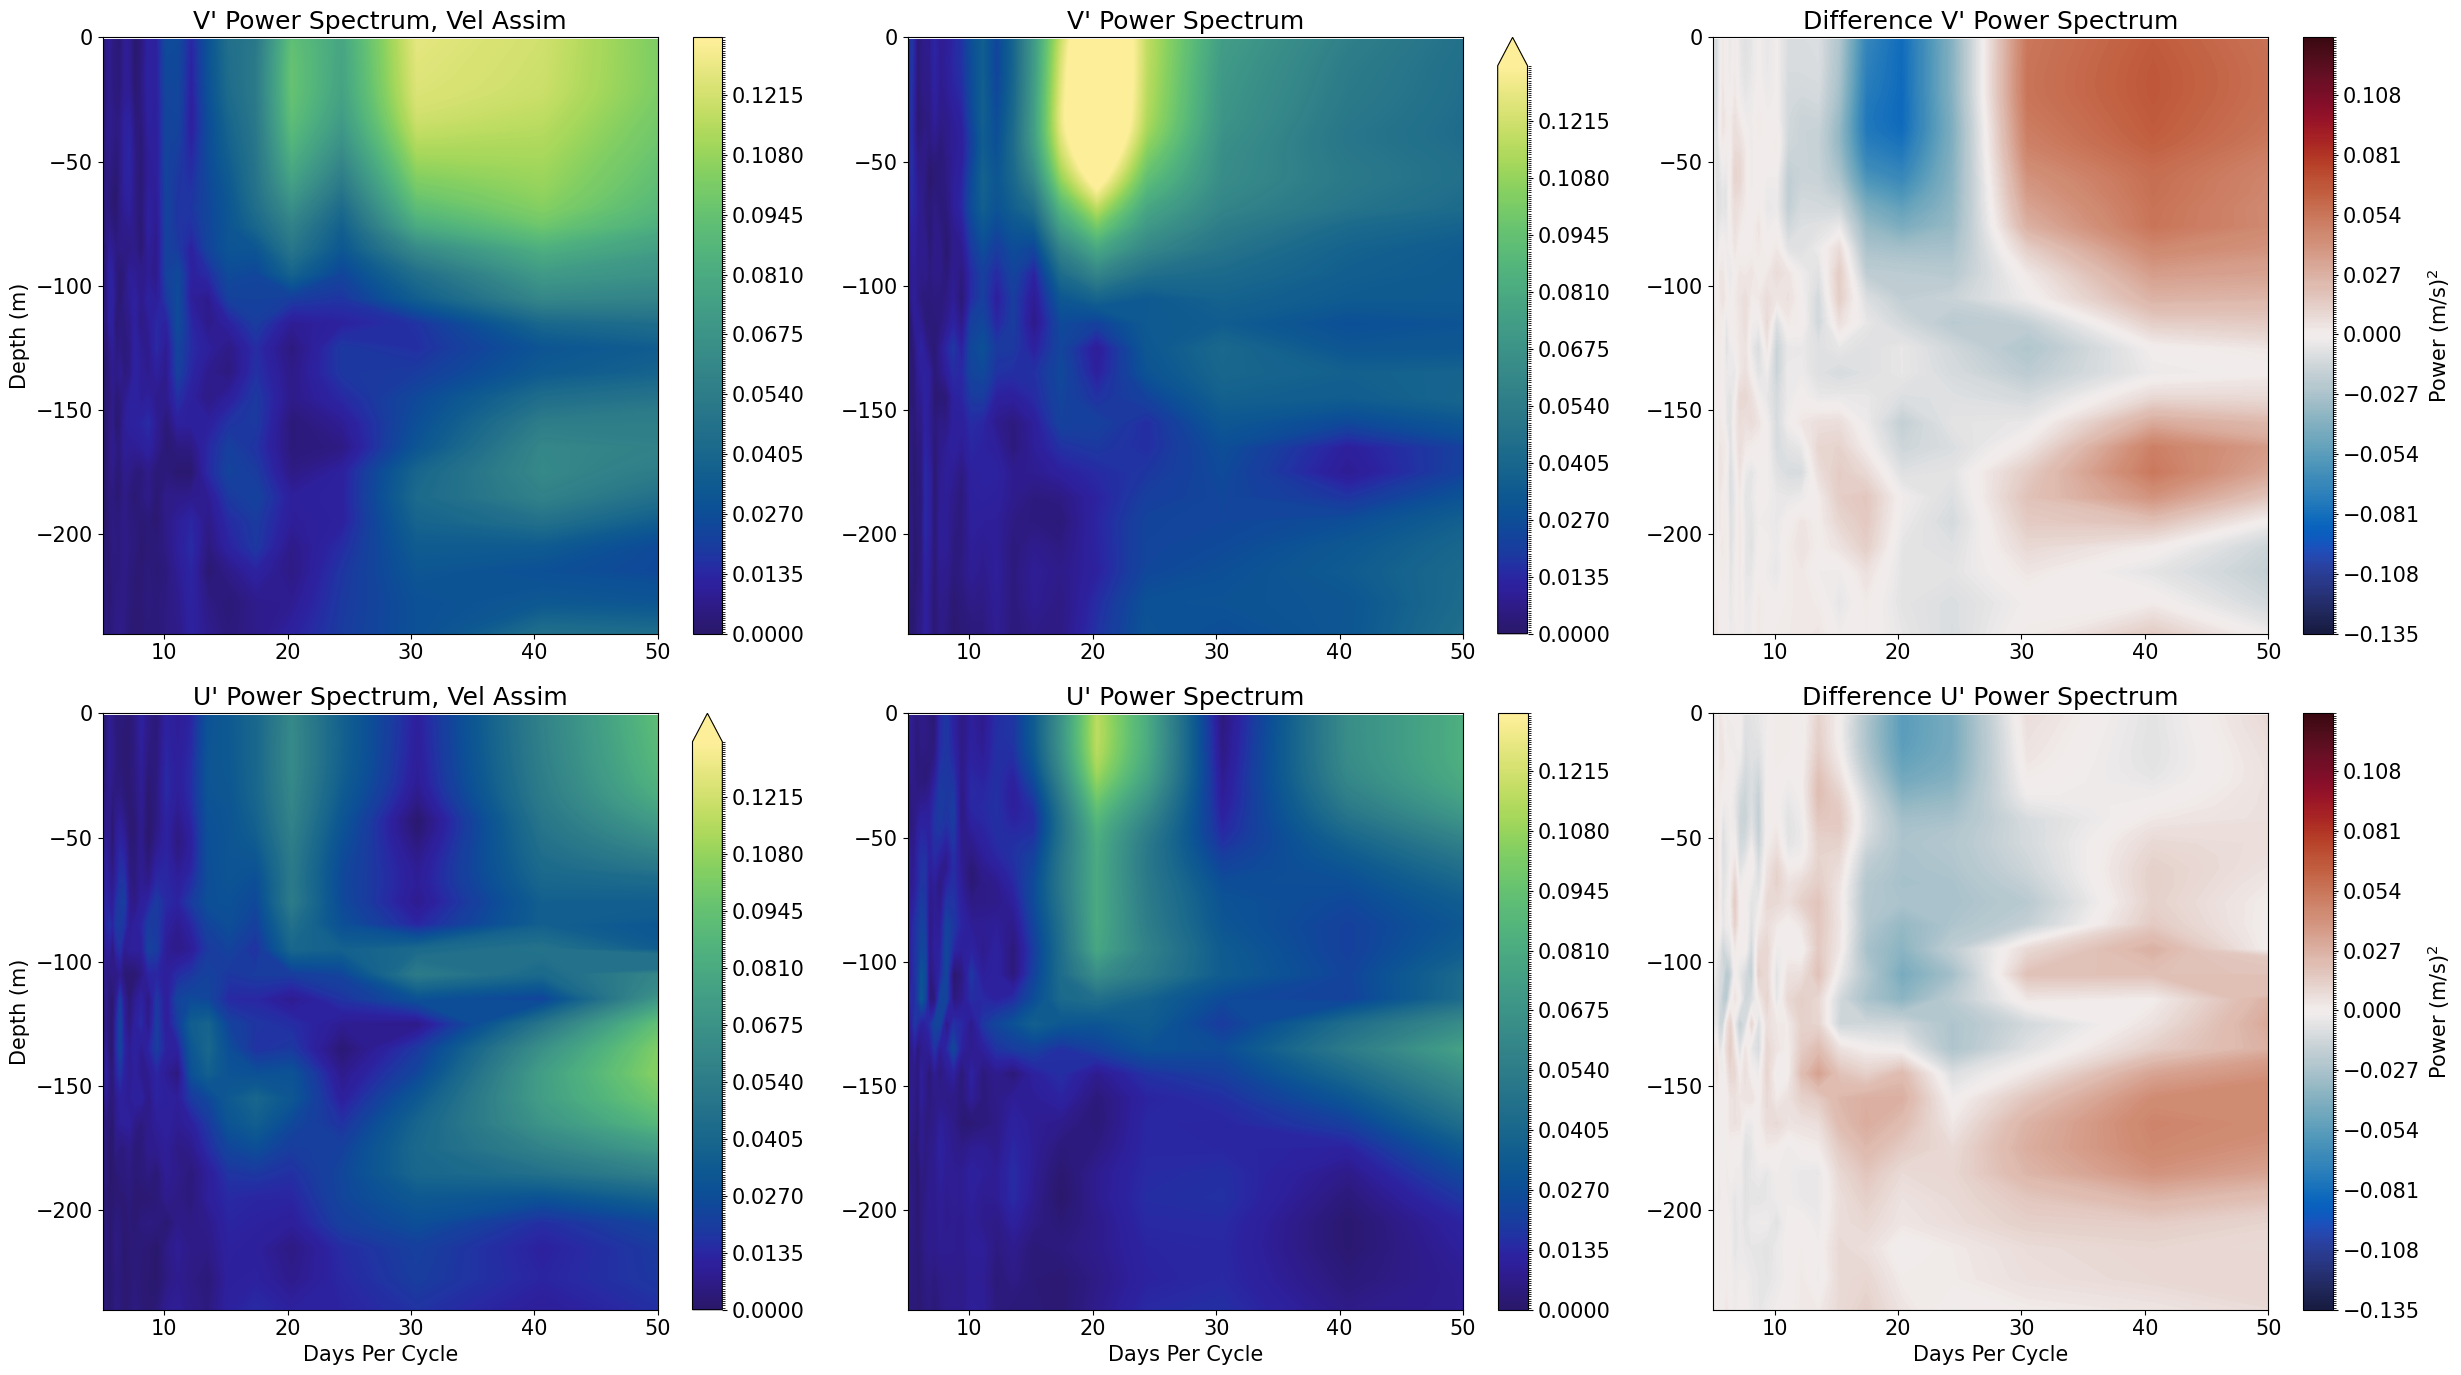

In [14]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(ncols=3, nrows=2,figsize=(25,14))
levels = np.arange(0,0.135,0.0005)
amp1_vel.plot.contourf(levels=levels,x='time',y='Z',ax=ax[0,0],cmap=cmo.haline,cbar_kwargs={'label': ''})
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Depth (m)')
ax[0,0].set_ylim(-240,0)  
ax[0,0].set_xlim(5,50)
ax[0,0].set_title('V\' Power Spectrum, Vel Assim')

amp2_vel.plot.contourf(levels=levels,x='time',y='Z',ax=ax[1,0],cmap=cmo.haline,cbar_kwargs={'label': ''})
ax[1,0].set_xlabel('Days Per Cycle')
ax[1,0].set_ylabel('Depth (m)')
ax[1,0].set_ylim(-240,0)
ax[1,0].set_xlim(5,50)
ax[1,0].set_title('U\' Power Spectrum, Vel Assim')

amp1.plot.contourf(levels=levels,x='time',y='Z',ax=ax[0,1],cmap=cmo.haline,cbar_kwargs={'label': ''})
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')
ax[0,1].set_ylim(-240,0)  
ax[0,1].set_xlim(5,50)
ax[0,1].set_title('V\' Power Spectrum')

amp2.plot.contourf(levels=levels,x='time',y='Z',ax=ax[1,1],cmap=cmo.haline,cbar_kwargs={'label': ''})
ax[1,1].set_xlabel('Days Per Cycle')
ax[1,1].set_ylabel('')
ax[1,1].set_ylim(-240,0)
ax[1,1].set_xlim(5,50)
ax[1,1].set_title('U\' Power Spectrum')

levels = np.arange(-0.135,0.135,0.001)
(amp1_vel - amp1).plot.contourf(levels=levels,x='time',y='Z',ax=ax[0,2],cmap=cmo.balance,cbar_kwargs={'label': 'Power (m/s)$^2$'})
ax[0,2].set_xlabel('')
ax[0,2].set_ylabel('')
ax[0,2].set_ylim(-240,0)  
ax[0,2].set_xlim(5,50)
ax[0,2].set_title('Difference V\' Power Spectrum')

(amp2_vel - amp2).plot.contourf(levels=levels,x='time',y='Z',ax=ax[1,2],cmap=cmo.balance,cbar_kwargs={'label': 'Power (m/s)$^2$'})
ax[1,2].set_xlabel('Days Per Cycle')
ax[1,2].set_ylabel('')
ax[1,2].set_ylim(-240,0)
ax[1,2].set_xlim(5,50)
ax[1,2].set_title('Difference U\' Power Spectrum')

plt.tight_layout()
plt.show()

fig.savefig(folder_name+'velocity_spectrum_TIW.png')

#### Shutdown

In [1]:
cluster.close()
client.shutdown()
client.close()

NameError: name 'cluster' is not defined